In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write

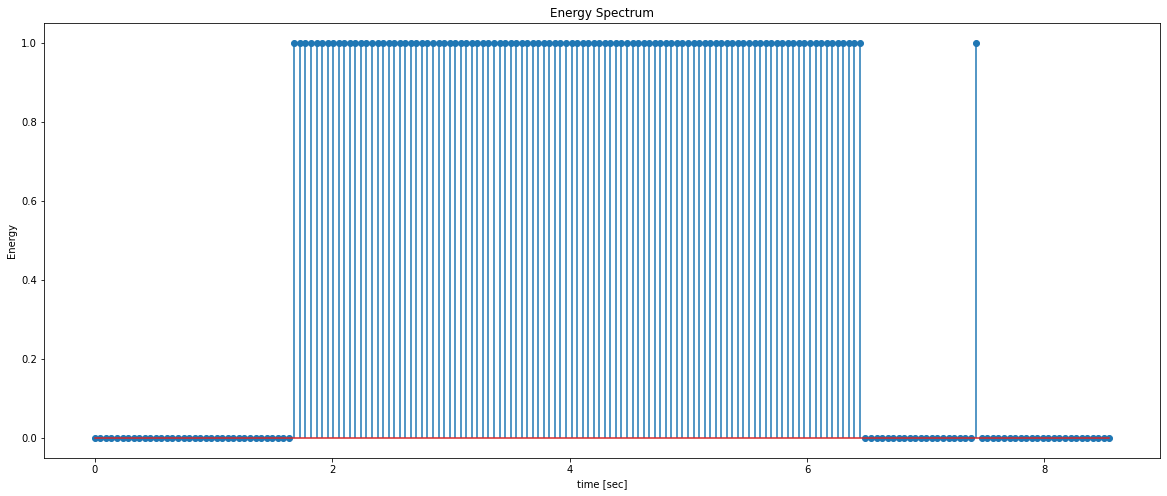

In [33]:
FRAME_SIZE = 2048

def ece420ProcessFrame(frame, threshold = 100e7):
    isVoiced = 0

    #### YOUR CODE HERE ####
    sum = 0
    for n in range(len(frame)):
        sum += abs(frame[n])**2

    if sum > threshold:
        isVoiced = 1

    # print("sum: {}".format(sum))
    return isVoiced


################# GIVEN CODE BELOW #####################

Fs, data = read('test_vector.wav')

numFrames = int(len(data) / FRAME_SIZE)
framesVoiced = np.zeros(numFrames)
t = np.linspace(0, len(data)/Fs, numFrames)

for i in range(numFrames):
    frame = data[i * FRAME_SIZE : (i + 1) * FRAME_SIZE]
    framesVoiced[i] = ece420ProcessFrame(frame.astype(float))

plt.figure(figsize=(20,8))
plt.stem(t, framesVoiced)
plt.title("Energy Spectrum")
plt.xlabel("time [sec]")
plt.ylabel("Energy")
plt.show()

In [34]:
# peak detection functions from lab 1 for help

def peak_detection(t, sig):
    """
    Description: Retrieve the max peak from a given array of positions and signal values
    :param t:
    :param sig:
    :return:
    """
    peaks = []
    max_val = -np.Inf
    N = len(sig)

    for i in range(0, N):
        if sig[i] > max_val:
            max_val = sig[i]
            position = t[i]
    peaks.append((position, max_val))
    return np.array(peaks)

def multiple_peak_detection(t, sig, thresh=3):
    """
    Description: For every continuous signal above the specified threshold, retrieve its local maxima
    :param t:
    :param sig:
    :param thresh:
    :return:
    """
    peaks = []
    N = len(sig)

    thresh_indices = np.where(sig > thresh)[0] # retrive all sig indices that are above the threshold
    curr_start = thresh_indices[0] # starting slice
    curr_end = None # ending slice
    for i in range(1, len(thresh_indices)):
        idx = thresh_indices[i]

        # update curr_end if indices are still continuous
        if curr_end is None or idx - 1 == curr_end:
            curr_end = idx
            continue

        # if indices are no longer continuous, process previous continuous signal and then reset curr_start and curr_end
        if curr_end is not None and idx - 1 != curr_end:
            peaks.append(peak_detection(t[curr_start:curr_end], sig[curr_start:curr_end])[0])
            curr_start = idx
            curr_end = None

    return np.array(peaks)

In [35]:
fs = 8000        # Sampling Rate is 8000
duration = 1     # 1 sec
t = np.linspace(0,duration,duration*fs)
freq = 10        # Tune Frequency is 10 Hz
tune = np.sin(2*np.pi*freq*t)

# Add some Gaussian noise 
tune += np.random.normal(0, 0.5, duration * fs)



# Start a new figure for your autocorrelation plot 
# Your code here
max_sum = 0
max_l = 0
frames = np.zeros(len(tune))
for l in range(len(tune)):
    sum_top = 0
    sum_bottom = 0
    for n in range(len(tune)):
        sum_top += tune[n]*tune[((n - l)%len(tune) + len(tune))%len(tune)]
        sum_bottom += tune[n]**2
    curr_sum = sum_top / sum_bottom
    if curr_sum > max_sum:
        max_sum = curr_sum
        max_l = l
    frames[l] = curr_sum

t = np.linspace(0, duration, len(frames))
frequncies = np.linspace(0, fs/2, len(frames))
max_arg = np.argmax(frames[10:]) + 10
print("Rxx[{}] = {} with frequncy {} Hz".format(max_l, max_sum, frequncies[max_l]))


Rxx[0] = 1.0 with frequncy 0.0 Hz


[[0.         1.        ]
 [0.10101263 0.67431302]
 [0.20027503 0.67648521]
 [0.3007876  0.67862031]
 [0.39879985 0.67506271]
 [0.4991874  0.67527244]
 [0.60132517 0.67506271]
 [0.69933742 0.67862031]
 [0.79984998 0.67648521]
 [0.89911239 0.67431302]]
l at: 808. Fundamental period of 0.101 seconds and fundamental frequency of 9.900990099009901 Hz


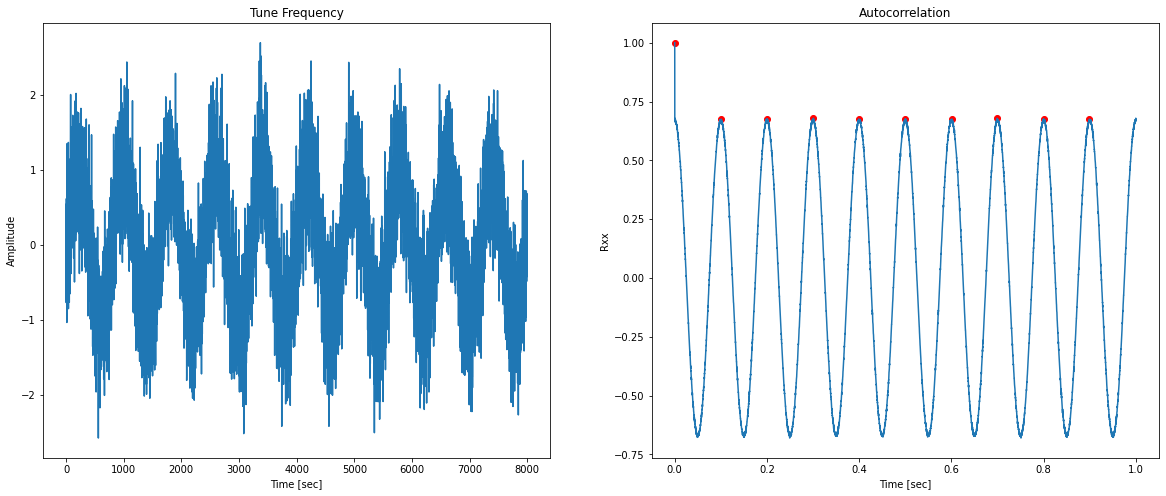

In [36]:

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(tune)
plt.title("Tune Frequency")
plt.xlabel("Time [sec]")
plt.ylabel("Amplitude")
peaks = multiple_peak_detection(t, frames, 0.50)
print(peaks)
l = np.argwhere(t == peaks[1,0])[0,0]
print("l at: {}. Fundamental period of {} seconds and fundamental frequency of {} Hz".format(l, l/fs, fs/l))

plt.subplot(122)
plt.plot(t, frames)
plt.title("Autocorrelation")
plt.xlabel("Time [sec]")
plt.ylabel("Rxx")
plt.scatter(peaks[:, 0], peaks[:, 1], color='red')
# Only call plt.show() at the very end of the script 
plt.show()


A lag of l = 0 maximizes Rxx but this typically leads to a bad estimation. By ignoring the first peak and looking at the next local maxima, I found that a lag of 808 caused a maxima that is repeated, and its period and frequency was 0.101 seconds and 9.9 Hz. 